# Setup for prostate segmentation using Unet

First setup and code, based on assignment 7 from ISMI and https://codecampanion.blogspot.com/2018/12/hello-this-rather-quick-and-dirty.html, https://github.com/zhixuhao/unet/blob/master/data.py

## Loading in libraries and setting parameters

In this cell you can choose the size of the image, the percentage of the data that is used for validation, the padding of the images and the user.

In [ ]:
# Setting initial parameters
USER = 0  # 0 = Sonja, 1 = Marit, 2 = Wieske, 3 = Rudo

seed = 1               # Setting random seed
IMG_HEIGHT = 320
IMG_WIDTH = 320
VAL_PERCENT = 0.2
PADDING = 'same'       # set to 'valid' or 'same'
NORM = 'channel'       # Choose normalization on 'image' or 'channel'
techniques = 'Both'    # Choose 'T2', 'ADC' or 'Both'
resample = True        # Resample images with shapes different from (IMG_HEIGHT, IMG_WIDTH)
colab = True

if techniques == 'Both':
    IMG_CHANNELS = 2
elif techniques == 'T2' or techniques == 'ADC':
    IMG_CHANNELS = 1
else:
    print('This is bullshit!')

In [ ]:
# Load the data from Google Drive or define the local data directory
!pip install SimpleITK

if USER == 0:
    if colab:
        # Load data by mounting Google Drive (with unzipped data)
        from google.colab import drive
        drive.mount('/content/drive')
        import os
        if os.getcwd() != "/content/drive/My Drive/MSc Data Science/2. Semester/ISMI/Project Prostate":
            os.chdir("drive/My Drive/MSc Data Science/2. Semester/ISMI/Project Prostate/")
        # Define data directory
        data_dir = './Data'
        weight_path = './model_weights'
    else:
        data_dir = '../Data'
        weight_path = '../model_weights'
if USER == 1:
    data_dir = './Task05_Prostate/'
if USER == 2:
    # Load data by downloading and extracting the tarfile from Google Drive
    # Install the PyDrive wrapper & import libraries.
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    # Download a file based on its file ID. ID can be found in file sharing link
    file_id = '1ZVEVol0mnjX3mylZbN3hw53sSRDB_g3N' # replace with own ID
    download = drive.CreateFile({'id': file_id})
    download.GetContentFile('Task05_Prostate.tar')
    # Extract tarfile
    import tarfile
    tf = tarfile.open("Task05_Prostate.tar")
    tf.extractall()
    # Define data directory
    data_dir = './Task05_Prostate/'
if USER == 3:
    data_dir = './'
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    if os.getcwd() != '/content/drive/My Drive/Colab_data/ISMI':
        os.chdir("drive/My Drive/Colab_data/ISMI")

     |████████████████████████████████| 42.5MB 102.0MB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Importing libraries
import os
import sys
import random
import warnings
import glob

import numpy as np
import pandas as pd

import SimpleITK as sitk
import matplotlib.pyplot as plt
import scipy.misc

from tqdm import tqdm
from itertools import chain
import skimage.io as io
import skimage.transform as trans
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose, Cropping2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras import regularizers
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

Using TensorFlow backend.


## Loading in data

In [ ]:
def resample(image): 
    image = sitk.GetImageFromArray(image)
    euler2d = sitk.Euler2DTransform()
    euler2d.SetCenter(image.TransformContinuousIndexToPhysicalPoint(np.array(image.GetSize())/2.0))
    tx, ty = image.GetSize()
    euler2d.SetTranslation((tx, ty))
    extreme_points = [image.TransformIndexToPhysicalPoint((0,0)),
                      image.TransformIndexToPhysicalPoint((image.GetWidth(),0)),
                      image.TransformIndexToPhysicalPoint((image.GetWidth(),image.GetHeight())),
                      image.TransformIndexToPhysicalPoint((0,image.GetHeight()))]
    inv_euler2d = euler2d.GetInverse()
    extreme_points_transformed = [inv_euler2d.TransformPoint(pnt) for pnt in extreme_points]
    min_x = min(extreme_points_transformed)[0]
    min_y = min(extreme_points_transformed, key=lambda p: p[1])[1]
    max_x = max(extreme_points_transformed)[0]
    max_y = max(extreme_points_transformed, key=lambda p: p[1])[1]
   
    # Identity cosine matrix
    output_direction = [1.0, 0.0, 0.0, 1.0]
    # Minimal x,y coordinates are the new origin
    output_origin = [min_x, min_y]
    # Grid size 
    output_size = [IMG_HEIGHT, IMG_WIDTH]
    # Compute spacing
    output_spacing = image.GetSpacing()*np.array([tx, ty])/output_size

    resampled_image = sitk.Resample(image, output_size, euler2d, sitk.sitkNearestNeighbor, output_origin, output_spacing, output_direction)
    
    #plt.imshow(sitk.GetArrayViewFromImage(resampled_image))
    #plt.axis('off')
    #plt.show()
    
    return sitk.GetArrayFromImage(resampled_image)



In [ ]:
# Load in training data, labels and test data

# Get directory names
train_dir = os.path.join(data_dir, 'imagesTr/')
train_lbl_dir = os.path.join(data_dir, 'labelsTr/')
test_dir = os.path.join(data_dir, 'imagesTs/')

# Get filenames
train_imgs = [os.path.join(train_dir, filename) for filename in os.listdir(train_dir) if not filename.startswith('._')]
train_lbls = [os.path.join(train_lbl_dir, filename) for filename in os.listdir(train_lbl_dir) if not filename.startswith('._')]
test_imgs = [os.path.join(test_dir, filename) for filename in os.listdir(test_dir) if not filename.startswith('._')]

# Get numpy arrays as 2d slices from 3d images
imgs2D = [] # List of 2D images
lbls2D = [] # List of 2D labels (Masks)
for image, label in zip(sorted(train_imgs), sorted(train_lbls)):
    sitkImg = sitk.ReadImage(image)
    img3D = sitk.GetArrayFromImage(sitkImg) # Gets np.arrays of shape (2, nb_2Dimgs, 320, 320)
    lbl3D = sitk.GetArrayFromImage(sitk.ReadImage(label)) # Gets np.arrays of shape (nb_2dimgs, 320, 320)
                                                          # 0 = Not prostate, 1 = P-zone, 2 = T-zone
    img3D = np.moveaxis(img3D, 0, -1)       

    if img3D.shape[2]!=IMG_HEIGHT and resample: # Resample all images with shape other than 320x320 if resample==True
        for img2D in img3D:
            resampled_t2 = resample(img2D[..., 0])
            resampled_adc = resample(img2D[..., 1])
            resampled_img = np.stack((resampled_t2, resampled_adc), axis=2)
            imgs2D.append(resampled_img)
        for lbl2D in lbl3D:
            resampled_lbl = resample(lbl2D)
            lbls2D.append(resampled_lbl)
    elif resample: 
        for img2D in img3D:
            imgs2D.append(img2D)
        for lbl2D in lbl3D:
            lbls2D.append(lbl2D)
            
imgs2D = np.stack(imgs2D)
lbls2D = np.stack(lbls2D)

test_imgs3D = [] # List of 3D test images
for test_image in test_imgs:
    test_img3D = sitk.GetArrayFromImage(sitk.ReadImage(test_image))
    test_img3D = np.moveaxis(test_img3D, 0, -1)
    test_imgs3D.append(test_img3D)
test_imgs2D = np.concatenate(test_imgs3D, axis = 0)

# Shuffle images
indexes = list(range(len(imgs2D)))
random.shuffle(indexes)
imgs2D = imgs2D[indexes]
lbls2D = lbls2D[indexes]

# One hot encode labels
lbls2D_onehot = to_categorical(lbls2D)

# Create validation set
n_validation_imgs = int(VAL_PERCENT * len(imgs2D))
train_imgs2D = imgs2D[n_validation_imgs:]
train_lbls2D = lbls2D[n_validation_imgs:]
train_lbls2D_onehot = lbls2D_onehot[n_validation_imgs:]
val_imgs2D = imgs2D[:n_validation_imgs]
val_lbls2D = lbls2D[:n_validation_imgs]
val_lbls2D_onehot = lbls2D_onehot[:n_validation_imgs]

# Normalize images
if NORM == 'image':  # normalize per image per channel
    imagemax = np.max(imgs2D, axis=(1,2))
    imagemax = np.reshape(imagemax, (imagemax.shape[0], 1, 1, imagemax.shape[1]))
    imagemax[imagemax==0] = 1
    train_imgs2D = np.divide(train_imgs2D, imagemax[n_validation_imgs:])
    val_imgs2D = np.divide(val_imgs2D, imagemax[:n_validation_imgs])
else:  # normalize per channel
    channelmax = np.max(train_imgs2D, axis=(0,1,2))
    train_imgs2D = np.divide(train_imgs2D, channelmax)
    val_imgs2D = np.divide(val_imgs2D, channelmax)

# Resize/remove data based on initial parameters
if PADDING == 'valid':
  train_lbls2D_onehot = train_lbls2D_onehot[:, 46:-46, 46:-46, :]
  val_lbls2D_onehot = val_lbls2D_onehot[:, 46:-46, 46:-46, :]
if techniques == 'T2':
  train_imgs2D = train_imgs2D[..., 1][:, :, :, None] 
  val_imgs2D = val_imgs2D[..., 1][:, :, :, None]  
if techniques == 'ADC':
  train_imgs2D = train_imgs2D[..., 0][:, :, :, None] 
  val_imgs2D = val_imgs2D[..., 0][:, :, :, None] 

## Creating U-net model

In [ ]:
def unet_block(inputs, n_filters, padding='same', dropout_rate=0.0, batchnorm=False, regrate=0.001):
    '''Creates a U-net block with two convolutional layers and optionally batchnormalization, dropout and/or l2 regularization'''
    cl = Conv2D(n_filters, 5, activation='relu', padding=padding, 
                kernel_initializer='glorot_normal',
                kernel_regularizer=regularizers.l2(regrate))(inputs)
    if dropout_rate > 0:
        cl = Dropout(dropout_rate)(cl)
    if batchnorm:
        cl = BatchNormalization()(cl)
    cl = Conv2D(n_filters, 5, activation='relu', padding=padding, 
                kernel_initializer='glorot_normal',
                kernel_regularizer=regularizers.l2(regrate))(cl)
    if dropout_rate > 0:
        cl = Dropout(dropout_rate)(cl)
    if batchnorm:
        cl = BatchNormalization()(cl)
    return cl

def build_unet(initial_filters=32, n_classes=3, padding='same', dropout_rate=0.0, batchnorm=False, regrate=0.001, printmodel=False):
    '''Creates a U-net model with a depth of four (3 pooling layers) by using the unet_block function'''
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    cropped = inputs
    if padding == 'valid':
        # Crop size to 316 x 316:
        cropped = Cropping2D(cropping=2)(inputs)

    # CONTRACTION PART    
    # First conv pool
    c1 = unet_block(cropped, initial_filters, padding, dropout_rate, batchnorm, regrate)
    p1 = MaxPooling2D()(c1)

    # Second conv pool
    c2 = unet_block(p1, 2*initial_filters, padding, dropout_rate, batchnorm, regrate)
    p2 = MaxPooling2D()(c2)

    # Third conv pool
    c3 = unet_block(p2, 4*initial_filters, padding, dropout_rate, batchnorm, regrate)
    p3 = MaxPooling2D()(c3)

    # Fourth conv
    c4 = unet_block(p3, 8*initial_filters, padding, dropout_rate, batchnorm, regrate)

    # EXPANSION PART
    # First up-conv
    u1 = UpSampling2D()(c4)
    if padding == 'valid':
        crop = (int(c3.shape[1])-int(u1.shape[1]))//2
        c3 = Cropping2D(cropping=crop)(c3)
    m1 = concatenate([c3, u1])
    cm1 = unet_block(m1, 4*initial_filters, padding, dropout_rate, batchnorm, regrate)

    # Second up-conv
    u2 = UpSampling2D()(cm1)
    if padding == 'valid':
        crop = int((c2.shape[1])-int(u2.shape[1]))//2
        c2 = Cropping2D(cropping=crop)(c2)
    m2 = concatenate([c2, u2])
    cm2 = unet_block(m2, 2*initial_filters, padding, dropout_rate, batchnorm, regrate)

    # Third up-conv
    u3 = UpSampling2D()(cm2)
    if padding == 'valid':
        crop = int((c1.shape[1])-int(u3.shape[1]))//2
        c1 = Cropping2D(cropping=crop)(c1)
    m3 = concatenate([c1, u3])
    cm3 = unet_block(m3, initial_filters, padding, dropout_rate, batchnorm, regrate)

    # Output
    predictions = Conv2D(n_classes, 1, activation='softmax')(cm3)
    model = Model(inputs, predictions)
    
    if printmodel:
        print(model.summary())
    
    return model

In [ ]:
def build_3level_unet(initial_filters=32, n_classes=3, padding='same', dropout_rate=0.0, batchnorm=False, regrate=0.001, printmodel=False):
    '''Creates a U-net model with a depth of three (2 pooling layers) by using the unet_block function'''
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    cropped = inputs
    if padding == 'valid':
        # Crop size to 316 x 316:
        cropped = Cropping2D(cropping=2)(inputs)

    # CONTRACTION PART    
    # First conv pool
    c1 = unet_block(cropped, initial_filters, padding, dropout_rate, batchnorm, regrate)
    p1 = MaxPooling2D()(c1)

    # Second conv pool
    c2 = unet_block(p1, 2*initial_filters, padding, dropout_rate, batchnorm, regrate)
    p2 = MaxPooling2D()(c2)

    # Third conv pool
    c3 = unet_block(p2, 4*initial_filters, padding, dropout_rate, batchnorm, regrate)
    
    
    # EXPANSION PART
    # First up-conv
    u1 = UpSampling2D()(c3)
    if padding == 'valid':
        crop = (int(c2.shape[1])-int(u1.shape[1]))//2
        c2 = Cropping2D(cropping=crop)(c2)
    m1 = concatenate([c2, u1])
    cm1 = unet_block(m1, 4*initial_filters, padding, dropout_rate, batchnorm, regrate)

    # Second up-conv
    u2 = UpSampling2D()(cm1)
    if padding == 'valid':
        crop = int((c1.shape[1])-int(u2.shape[1]))//2
        c1 = Cropping2D(cropping=crop)(c1)
    m2 = concatenate([c1, u2])
    cm2 = unet_block(m2, 2*initial_filters, padding, dropout_rate, batchnorm, regrate)

    
    # Output
    predictions = Conv2D(n_classes, 1, activation='softmax')(cm2)
    model = Model(inputs, predictions)
    
    if printmodel:
        print(model.summary())
    
    return model


def build_5level_unet(initial_filters=32, n_classes=3, padding='same', dropout_rate=0.0, batchnorm=False, regrate=0.001, printmodel=False):
    '''Creates a U-net model with a depth of five (4 pooling layers) by using the unet_block function'''
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    cropped = inputs
    if padding == 'valid':
        # Crop size to 316 x 316:
        cropped = Cropping2D(cropping=2)(inputs)

    # CONTRACTION PART    
    # First conv pool
    c1 = unet_block(cropped, initial_filters, padding, dropout_rate, batchnorm, regrate)
    p1 = MaxPooling2D()(c1)

    # Second conv pool
    c2 = unet_block(p1, 2*initial_filters, padding, dropout_rate, batchnorm, regrate)
    p2 = MaxPooling2D()(c2)

    # Third conv pool
    c3 = unet_block(p2, 4*initial_filters, padding, dropout_rate, batchnorm, regrate)
    p3 = MaxPooling2D()(c3)

    # Fourth conv pool
    c4 = unet_block(p3, 8*initial_filters, padding, dropout_rate, batchnorm, regrate)
    p4 = MaxPooling2D()(c4)
    
    # Fifth conv pool
    c5 = unet_block(p4, 16*initial_filters, padding, dropout_rate, batchnorm, regrate)


    # EXPANSION PART
    # First up-conv
    u1 = UpSampling2D()(c5)
    if padding == 'valid':
        crop = (int(c4.shape[1])-int(u1.shape[1]))//2
        c4 = Cropping2D(cropping=crop)(c4)
    m1 = concatenate([c4, u1])
    cm1 = unet_block(m1, 4*initial_filters, padding, dropout_rate, batchnorm, regrate)

    # Second up-conv
    u2 = UpSampling2D()(cm1)
    if padding == 'valid':
        crop = int((c3.shape[1])-int(u2.shape[1]))//2
        c3 = Cropping2D(cropping=crop)(c3)
    m2 = concatenate([c3, u2])
    cm2 = unet_block(m2, 2*initial_filters, padding, dropout_rate, batchnorm, regrate)

    # Third up-conv
    u3 = UpSampling2D()(cm2)
    if padding == 'valid':
        crop = int((c2.shape[1])-int(u3.shape[1]))//2
        c2 = Cropping2D(cropping=crop)(c2)
    m3 = concatenate([c2, u3])
    cm3 = unet_block(m3, initial_filters, padding, dropout_rate, batchnorm, regrate)
    
    # Fourth up-conv
    u4 = UpSampling2D()(cm3)
    if padding == 'valid':
        crop = int((c1.shape[1])-int(u4.shape[1]))//2
        c1 = Cropping2D(cropping=crop)(c1)
    m4 = concatenate([c1, u4])
    cm4 = unet_block(m4, initial_filters, padding, dropout_rate, batchnorm, regrate)

    # Output
    predictions = Conv2D(n_classes, 1, activation='softmax')(cm4)
    model = Model(inputs, predictions)
    
    if printmodel:
        print(model.summary())
    
    return model

## Defining custom metrics and loss

In [ ]:
# Implement custom Keras metrics

def pz_acc(y_true_onehot, y_pred_prob):
    # Calculates the accuracy of the pz labels
    y_true = K.argmax(y_true_onehot, axis=3)
    y_pred = K.argmax(y_pred_prob, axis=3)
    
    y_true_pz = K.equal(y_true, 1) # True where y_true is pz
    y_pred_pz = K.equal(y_pred, 1) # True where y_pred is pz
    
    correct_pz = K.cast(K.equal(y_true_pz, y_pred_pz), K.floatx()) # True where y_pred correctly classified pz or not-pz
    n_correct_pz = K.sum(correct_pz) # Sum of correctly classified as pz or not-pz
    n_total = K.cast(K.prod(K.shape(y_true)), K.floatx()) # Number of all pixels
    return n_correct_pz/n_total
    
def tz_acc(y_true_onehot, y_pred_prob):
    # Calculates the accuracy of the tz labels
    y_true = K.argmax(y_true_onehot, axis=3)
    y_pred = K.argmax(y_pred_prob, axis=3)
    
    y_true_tz = K.equal(y_true, 2) # True where y_true is tz
    y_pred_tz = K.equal(y_pred, 2) # True where y_pred is tz
    
    correct_tz = K.cast(K.equal(y_true_tz, y_pred_tz), K.floatx()) # True where y_pred correctly classified tz or not-tz
    n_correct_tz = K.sum(correct_tz) # Sum of correctly classified as tz or not-tz
    n_total = K.cast(K.prod(K.shape(y_true)), K.floatx()) # Number of all pixels
    return n_correct_tz/n_total

def pz_dice(y_true_onehot, y_pred_prob):
    y_true = K.argmax(y_true_onehot, axis=3)
    y_pred = K.argmax(y_pred_prob, axis=3)
    
    y_true_pz = K.equal(y_true, 1) # True where y_true is pz
    y_pred_pz = K.equal(y_pred, 1) # True where y_pred is pz
    
    y_corr = K.equal(y_pred, y_true)# True where y_pred==y_true
    y_corr_pz = K.all(K.stack([y_pred_pz, y_corr], axis=0), axis=0) # True where y_pred==y_true==1
    n_correct_pz = K.sum(K.cast(y_corr_pz, K.floatx())) # Sum of correctly classified as pz

    n_true_pz = K.sum(K.cast(y_true_pz, K.floatx())) # Sum of true pz
    n_pred_pz = K.sum(K.cast(y_pred_pz, K.floatx())) # Sum of pred pz
    
    pz_dice = K.switch(K.equal(n_true_pz+n_pred_pz, 0), 1., (2*n_correct_pz) / (n_true_pz + n_pred_pz)) # dice is 1 if n_true_pz+n_pred_pz==0
    return pz_dice

def tz_dice(y_true_onehot, y_pred_prob):
    y_true = K.argmax(y_true_onehot, axis=3)
    y_pred = K.argmax(y_pred_prob, axis=3)
    
    y_true_tz = K.equal(y_true, 2) # True where y_true is tz
    y_pred_tz = K.equal(y_pred, 2) # True where y_pred is tz
    
    y_corr = K.equal(y_pred, y_true)# True where y_pred==y_true
    y_corr_tz = K.all(K.stack([y_pred_tz, y_corr], axis=0), axis=0) # True where y_pred==y_true==2
    n_correct_tz = K.sum(K.cast(y_corr_tz, K.floatx())) # Sum of correctly classified as tz

    n_true_tz = K.sum(K.cast(y_true_tz, K.floatx())) # Sum of true tz
    n_pred_tz = K.sum(K.cast(y_pred_tz, K.floatx())) # Sum of pred tz
    
    tz_dice = K.switch(K.equal(n_true_tz+n_pred_tz, 0), 1., (2*n_correct_tz) / (n_true_tz + n_pred_tz)) # dice is 1 if n_true_pz+n_pred_pz==0
    return tz_dice
  
def avg_dice(y_true, y_pred):
    return (tz_dice(y_true, y_pred) + pz_dice(y_true, y_pred))/ 2

In [ ]:
# Implemented a custom Keras loss
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    weights = K.variable(weights)  
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    return loss

In [ ]:
# Get class weights
nr_classes = 3
unique, counts = np.unique(train_lbls2D, return_counts=True)   # Get nr pixels of each train label
class_weights = np.sum(counts) / (nr_classes * counts)         # Calculate balanced class_weights
print(class_weights)

[ 0.34280083 48.75742497 16.03989696]


## Compile and train the unet model with data generator

In [ ]:
# Define data generators
data_gen_args = dict(#zoom_range = 0.2,
                     data_format="channels_last",
                     horizontal_flip = True
                    )

# Create data generators
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Fit data generators
image_datagen.fit(train_imgs2D, seed=seed)
mask_datagen.fit(train_lbls2D_onehot, seed=seed)

# Create training generator that combines training images and masks: 
image_generator = image_datagen.flow(train_imgs2D, batch_size=10, seed=seed)
mask_generator = mask_datagen.flow(train_lbls2D_onehot, batch_size=10, seed=seed)
train_generator = zip(image_generator, mask_generator)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:923: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (482, 320, 320, 2) (2 channels).
  ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (482, 320, 320, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


0.5693086 0.7992228


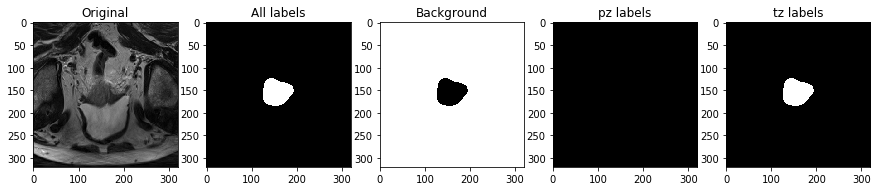

In [ ]:
# Check images that are created by the data generator
i, j = next(train_generator)
j2 = np.argmax(j, axis=3)  # to go from one-hot encoded version back to "normal" version
print(np.max(i[0, :, : , 0]), np.max(i[0, :, : , 1]))
if PADDING == 'valid':
    # pad images with background such that the size is the same as the input
    padding = np.zeros((j2.shape[0], IMG_HEIGHT, IMG_WIDTH))
    padding[:, 46:-46, 46:-46] = j2
    j2 = padding

    
plt.figure(figsize=(15, 5))
plt.subplot(151)
plt.title('Original')
plt.imshow(i[0, :, : ,0], cmap='gray')
plt.subplot(152)
plt.title('All labels')
plt.imshow(j2[0, :, :], cmap='gray') # shows all three labels
plt.subplot(153)
plt.title('Background')
plt.imshow(j[0, :, : ,0], cmap='gray') # shows the background labels
plt.subplot(154)
plt.title('pz labels')
plt.imshow(j[0, :, : ,1], cmap='gray') # shows pz labels
plt.subplot(155)
plt.title('tz labels')
plt.imshow(j[0, :, : ,2], cmap='gray') # shows tz labels
plt.show()

In [ ]:
model = build_5level_unet(
    initial_filters=32, 
    n_classes=3, 
    padding=PADDING, 
    dropout_rate=0.0, 
    batchnorm=True, 
    regrate=0.001, 
    printmodel=False)
optimizer = Adam(lr=0.0002, decay=0.0)
loss = weighted_categorical_crossentropy(weights = class_weights)
metrics = ['acc', pz_acc, tz_acc, pz_dice, tz_dice, avg_dice]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
def get_weight_path():
    runs = [int(name.split('_')[0]) for name in os.listdir('model_weights')]
    if len(runs)>0:
        run_nr = max(runs)+1
    else:
        run_nr = 1
    return os.path.join("model_weights", str(run_nr) + "_weights-epoch{epoch:02d}-pzdice{val_pz_dice:.2f}-tzdice{val_tz_dice:.2f}.h5")

In [ ]:
# Train the network
batch_size = 16
nr_epoch = 100

# Save the weights of the best model
if not os.path.exists('model_weights'):
    os.mkdir('model_weights')
modelpath = get_weight_path()
checkpoint = ModelCheckpoint(modelpath, 
                             monitor='val_avg_dice', 
                             save_best_only=True, 
                             mode = 'max', 
                             verbose=1)

# With data generator:
image_generator = image_datagen.flow(train_imgs2D, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(train_lbls2D_onehot, batch_size=batch_size, seed=seed)
train_generator = zip(image_generator, mask_generator)
training_history = model.fit_generator(train_generator, steps_per_epoch=len(image_generator),
                                       epochs=nr_epoch, verbose=1, callbacks=[checkpoint], 
                                       validation_data=(val_imgs2D,val_lbls2D_onehot))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (482, 320, 320, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
31/31 [==============================] - 54s 2s/step - loss: 3.1307 - acc: 0.5666 - pz_acc: 0.7591 - tz_acc: 0.7999 - pz_dice: 0.0373 - tz_dice: 0.1368 - avg_dice: 0.0870 - val_loss: 6.7959 - val_acc: 0.2243 - val_pz_acc: 0.8010 - val_tz_acc: 0.4168 - val_pz_dice: 0.0041 - val_tz_dice: 0.0572 - val_avg_dice: 0.0307

Epoch 00001: val_avg_dice improved from -inf to 0.03068, saving model to model_weights/32_weights-epoch01-pzdice0.00-tzdice0.06.h5
Epoch 2/100
31/31 [==============================] - 28s 907ms/step - loss: 2.8549 - acc: 0.7452 - pz_acc: 0.8566 - tz_acc: 0.8826 - pz_dice: 0.0703 - tz_dice: 0.2202 - avg_dice: 0.1452 - val_loss: 3.4231 - val_acc: 0.5418 - val_pz_acc: 0.8466 - val_tz_acc: 0.6906 - val_pz_dice: 0.0567 - val_tz_dice: 0.0903 - val_avg_dice: 0.0735

Epoch 00002: val_avg_dice improved from 0.03068 to 0.07350, saving model to mode

## Plot training history

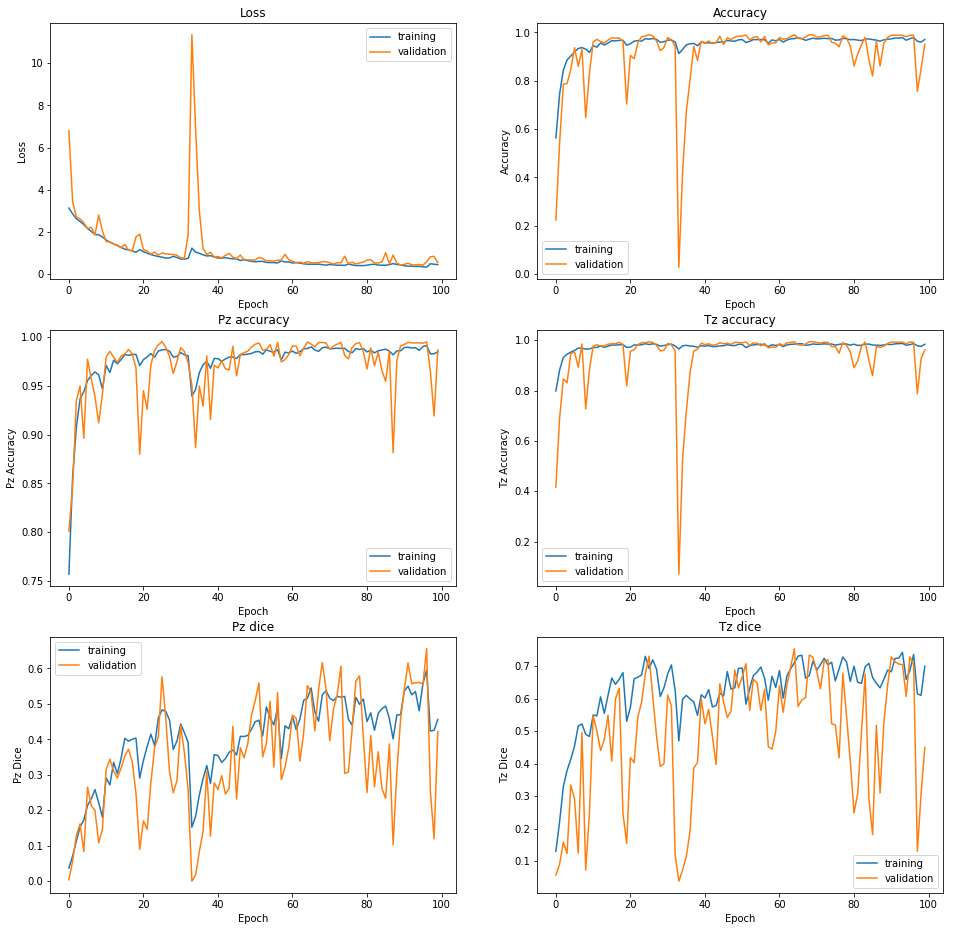

In [ ]:
plt.figure(figsize=(16,16))

plt.subplot(3,2,1)
plt.title('Loss')
plt.plot(training_history.history['loss'], label='training')
plt.plot(training_history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3,2,2)
plt.title('Accuracy')
plt.plot(training_history.history['acc'], label='training')
plt.plot(training_history.history['val_acc'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3,2,3)
plt.title('Pz accuracy')
plt.plot(training_history.history['pz_acc'], label='training')
plt.plot(training_history.history['val_pz_acc'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Pz Accuracy')
plt.legend()

plt.subplot(3,2,4)
plt.title('Tz accuracy')
plt.plot(training_history.history['tz_acc'], label='training')
plt.plot(training_history.history['val_tz_acc'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Tz Accuracy')
plt.legend()

plt.subplot(3,2,5)
plt.title('Pz dice')
plt.plot(training_history.history['pz_dice'], label='training')
plt.plot(training_history.history['val_pz_dice'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Pz Dice')
plt.legend()

plt.subplot(3,2,6)
plt.title('Tz dice')
plt.plot(training_history.history['tz_dice'], label='training')
plt.plot(training_history.history['val_tz_dice'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Tz Dice')
plt.legend()

plt.show()

## Reload best model

In [ ]:
# returns a compiled model
model = load_model(os.path.join(weight_path, '25_weights-epoch61-pzdice0.65-tzdice0.77.h5'), 
                   custom_objects={'pz_acc': pz_acc, 
                                   'tz_acc': tz_acc,
                                   'pz_dice': pz_dice,
                                   'tz_dice': tz_dice, 
                                   'avg_dice': avg_dice,
                                   'loss': weighted_categorical_crossentropy(weights = class_weights)})


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


##Show predictions on the validation set

In [ ]:
output_onehot = model.predict(val_imgs2D)
output = np.argmax(output_onehot, axis = -1)
if PADDING == 'valid':
    # pad images with background such that the size is the same as the input
    output_padded = np.zeros((output.shape[0], IMG_HEIGHT, IMG_WIDTH))
    output_padded[:, 46:-46, 46:-46] = output
    output = output_padded

True


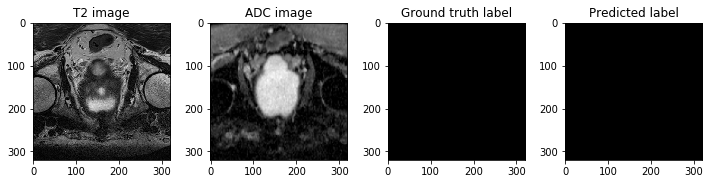

False


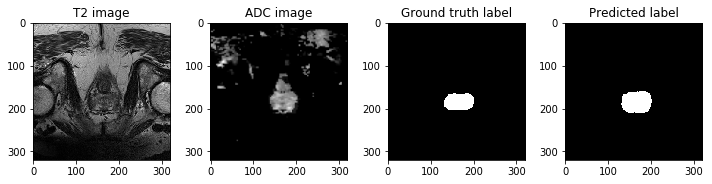

False


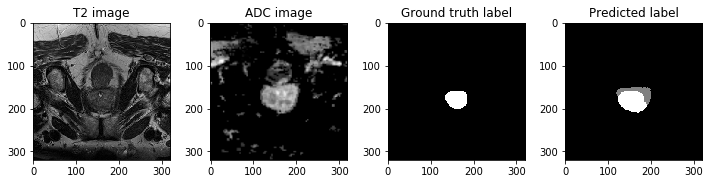

False


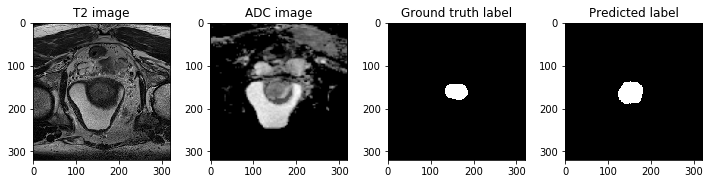

False


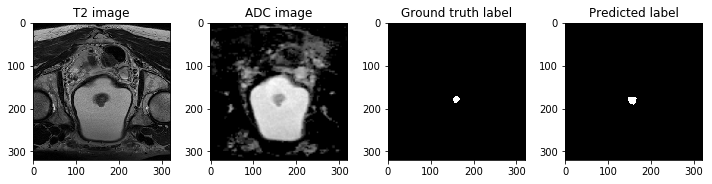

False


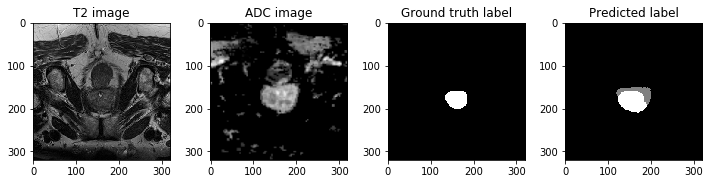

False


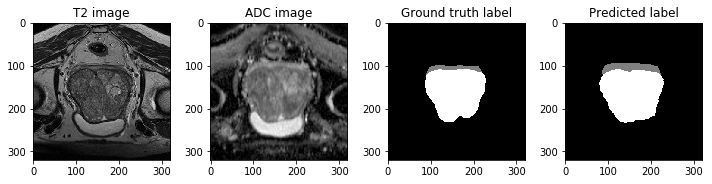

False


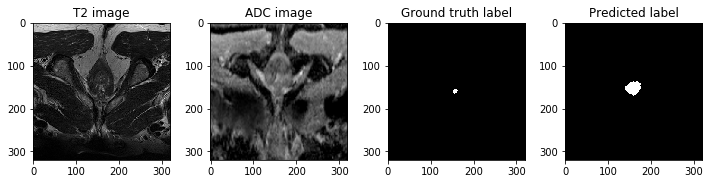

True


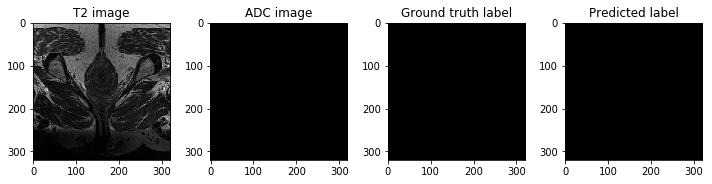

False


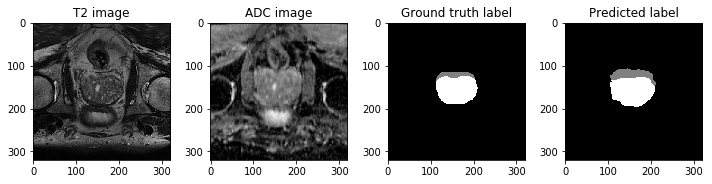

In [ ]:
pictures_to_show = np.random.randint(0, len(output), 10)

if techniques == 'Both':
    #for img_nb in range (10):            # First 10 pictures
    for img_nb in pictures_to_show:       # 10 random pictures
        plt.figure(figsize=(10,10))

        plt.subplot(1,4,1)
        plt.title('T2 image')
        plt.imshow(val_imgs2D[img_nb, :, : , 0], cmap='gray')

        plt.subplot(1,4,2)
        plt.title('ADC image')
        plt.imshow(val_imgs2D[img_nb, :, : , 1], cmap='gray')

        plt.subplot(1,4,3)
        plt.title('Ground truth label')
        plt.imshow(val_lbls2D[img_nb, :, : ], cmap='gray')

        plt.subplot(1,4,4)
        plt.title('Predicted label')
        plt.imshow(output[img_nb, :, :], cmap='gray')

        plt.tight_layout()
        plt.show()
else:
    #for img_nb in range (10):            # First 10 pictures
    for img_nb in pictures_to_show:       # 10 random pictures
        plt.figure(figsize=(10,10))

        plt.subplot(1,4,1)
        plt.title(techniques + ' image')
        plt.imshow(val_imgs2D[img_nb, :, : , 0], cmap='gray')

        plt.subplot(1,4,2)
        plt.title('Ground truth label')
        plt.imshow(val_lbls2D[img_nb, :, : ], cmap='gray')

        plt.subplot(1,4,3)
        plt.title('Predicted label')
        plt.imshow(output[img_nb, :, :], cmap='gray')

        plt.tight_layout()
        plt.show()

# Failure analysis
Hypotheses:  
Too much is classified as prostate --> compare total number of pixels per class  
Ratio pz-tz is inappropriate  
Number of images without prostate where prostate is detected vs number of images with prostate that is not detected  
Plot images with lowest dice  

In [ ]:
unique_true, counts_true = np.unique(val_lbls2D, return_counts=True)   # Get nr pixels of each val label
unique_pred, counts_pred = np.unique(output, return_counts=True)   # Get nr pixels of each predicted label
print('correct amount of pixels per class:  ', counts_true)
print('predicted amount of pixels per class:', counts_pred)
print('differences per class:               ', counts_pred-counts_true) 

print('correct ratio of pz vs tz:  ', counts_true[1]/counts_true[2]) 
print('predicted ratio of pz vs tz:', counts_pred[1]/counts_pred[2]) 

correct amount of pixels per class:   [11946104    70899   270997]
predicted amount of pixels per class: [11882947   124123   280930]
differences per class:                [-63157  53224   9933]
correct ratio of pz vs tz:   0.2616228223928678
predicted ratio of pz vs tz: 0.4418289253550707


In [ ]:
false_pos = 0
false_neg = 0
true_pos = 0
true_neg = 0
for true, pred in zip(val_lbls2D, output):
    if np.all(true==0) and not np.all(pred==0):
        false_pos += 1
    elif np.all(true==0) and np.all(pred==0):
        true_neg += 1
    elif not np.all(true==0) and np.all(pred==0):
        false_neg += 1
    else:
        true_pos += 1
print('    true false')
print('pos', true_pos, '  ', false_pos)
print('neg', false_neg, '   ', true_neg)

    true false
pos 96    2
neg 1     21


0.6172284644194757


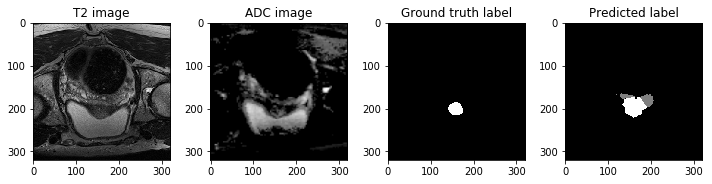

0.0


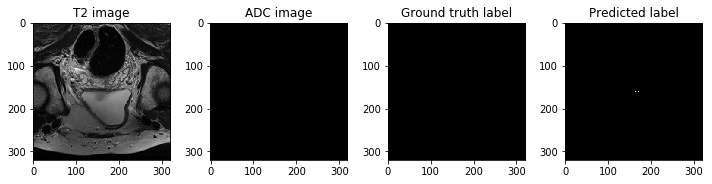

0.6865464632454924


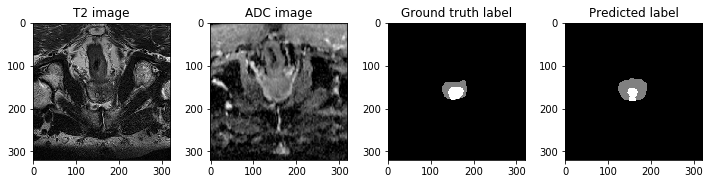

0.0


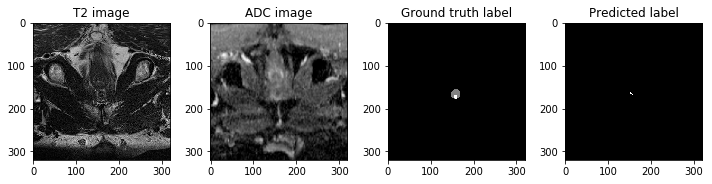

0.5983471074380166


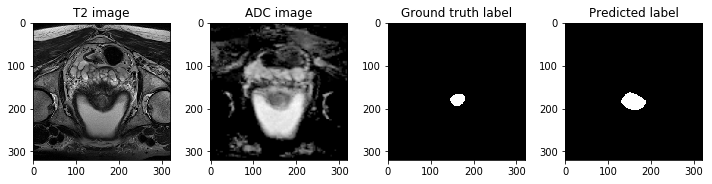

0.6410815525512429


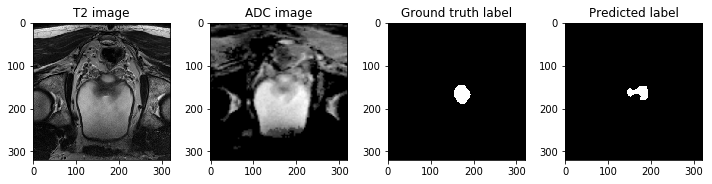

0.0


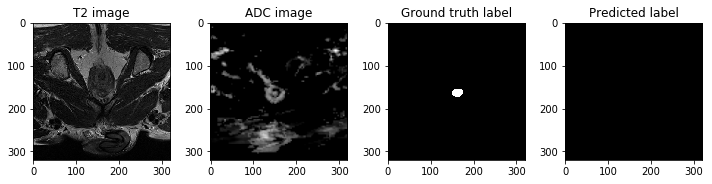

0.6946564885496184


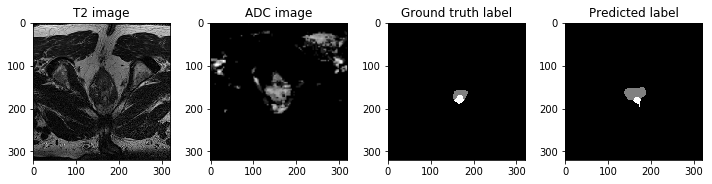

0.6515323496027242


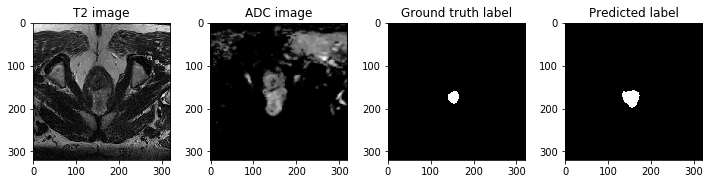

0.0


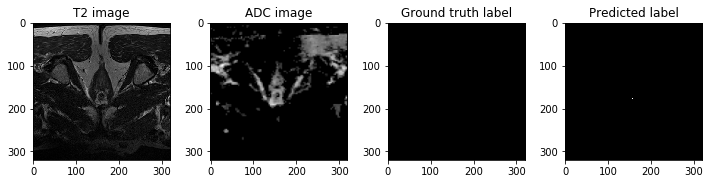

0.5125628140703518


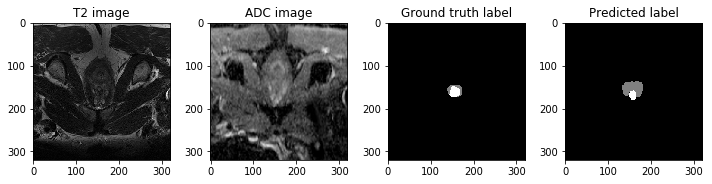

0.6370757180156658


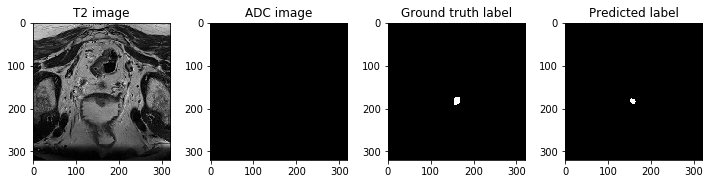

0.6942070275403609


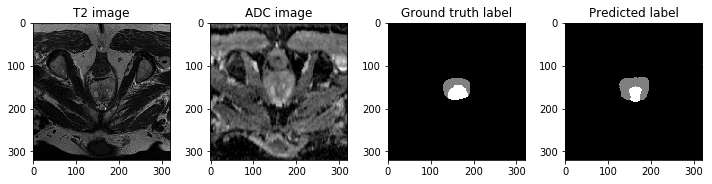

'\nfor val_lbl, out_lbl in zip(val_lbls2D, output):\n    tz_dice_score = tz_dice(val_lbl, out_lbl)\n    if tz_dice_score < 0.7:\n        print(tz_dice_score)\n        plt.plot(val_lbl, out_lbl)\n        '

In [ ]:
def tz_dice(y_true, y_pred):  
    y_true_tz = np.equal(y_true, 2) # True where y_true is tz
    y_pred_tz = np.equal(y_pred, 2) # True where y_pred is tz
    
    y_corr = np.equal(y_pred, y_true)# True where y_pred==y_true
    y_corr_tz = np.all(np.stack([y_pred_tz, y_corr], axis=0), axis=0) # True where y_pred==y_true==2
    n_correct_tz = np.sum(y_corr_tz) # Sum of correctly classified as tz

    n_true_tz = np.sum(y_true_tz) # Sum of true tz
    n_pred_tz = np.sum(y_pred_tz) # Sum of pred tz
    
    if n_true_tz+n_pred_tz == 0:
        tz_dice = 1.
    else: 
        tz_dice = (2*n_correct_tz) / (n_true_tz + n_pred_tz) # dice is 1 if n_true_pz+n_pred_pz==0
    return tz_dice

# display all images with a low dice score
for img_nb in range(len(output)):
    val_lbl = val_lbls2D[img_nb, :, : ]
    out_lbl = output[img_nb, :, :]
    tz_dice_score = tz_dice(val_lbl, out_lbl)
    
    if tz_dice_score < 0.7:
        print(tz_dice_score)
        plt.figure(figsize=(10,10))

        plt.subplot(1,4,1)
        plt.title('T2 image')
        plt.imshow(val_imgs2D[img_nb, :, : , 0], cmap='gray')

        plt.subplot(1,4,2)
        plt.title('ADC image')
        plt.imshow(val_imgs2D[img_nb, :, : , 1], cmap='gray')

        plt.subplot(1,4,3)
        plt.title('Ground truth label')
        plt.imshow(val_lbls2D[img_nb, :, : ], cmap='gray')

        plt.subplot(1,4,4)
        plt.title('Predicted label')
        plt.imshow(output[img_nb, :, :], cmap='gray')

        plt.tight_layout()
        plt.show()


# Graveyard

## Compile and train the U-net model without data generator

In [ ]:
'''
model = build_unet(
    initial_filters=16, 
    n_classes=3, 
    padding=PADDING, 
    dropout_rate=0.0, 
    batchnorm=False, 
    regrate=0.001, 
    printmodel=False)
optimizer = Adam(lr=0.0002, decay=0.0)
loss = weighted_categorical_crossentropy(weights = class_weights)
metrics = ['acc', pz_acc, tz_acc, pz_dice, tz_dice, avg_dice]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
'''

"\nmodel = build_unet(\n    initial_filters=16, \n    n_classes=3, \n    padding=PADDING, \n    dropout_rate=0.0, \n    batchnorm=False, \n    regrate=0.001, \n    printmodel=False)\noptimizer = Adam(lr=0.0002, decay=0.0)\nloss = weighted_categorical_crossentropy(weights = class_weights)\nmetrics = ['acc', pz_acc, tz_acc, pz_dice, tz_dice, avg_dice]\nmodel.compile(optimizer=optimizer, loss=loss, metrics=metrics)\n"

In [ ]:
'''
# Train the network
batch_size = 16
nr_epoch = 50


# Save the weights of the best model
if not os.path.exists('model_weights'):
    os.mkdir('model_weights')
modelpath = os.path.join("model_weights", "weights-epoch{epoch:02d}-dice{val_avg_dice:.2f}.h5")
checkpoint = ModelCheckpoint(modelpath, 
                             monitor='val_avg_dice', 
                             save_best_only=True, 
                             mode = 'max', 
                             verbose=1)


# With "normal" training data:
training_history = model.fit(x=train_imgs2D, 
                             y=train_lbls2D_onehot, 
                             batch_size=batch_size, 
                             epochs=nr_epoch, 
                             verbose=1, 
                             callbacks=[checkpoint],
                             validation_data=(val_imgs2D,val_lbls2D_onehot))
'''

'\n# Train the network\nbatch_size = 16\nnr_epoch = 50\n\n\n# Save the weights of the best model\nif not os.path.exists(\'model_weights\'):\n    os.mkdir(\'model_weights\')\nmodelpath = os.path.join("model_weights", "weights-epoch{epoch:02d}-dice{val_avg_dice:.2f}.h5")\ncheckpoint = ModelCheckpoint(modelpath, \n                             monitor=\'val_avg_dice\', \n                             save_best_only=True, \n                             mode = \'max\', \n                             verbose=1)\n\n\n# With "normal" training data:\ntraining_history = model.fit(x=train_imgs2D, \n                             y=train_lbls2D_onehot, \n                             batch_size=batch_size, \n                             epochs=nr_epoch, \n                             verbose=1, \n                             callbacks=[checkpoint],\n                             validation_data=(val_imgs2D,val_lbls2D_onehot))\n'